In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
# import seaborn as sns

import torch
import torch_geometric as tg

# sns.set()

In [2]:
df = pd.read_csv("dataset/Test_DGA_network.tsv", sep="\t", names=["disease", "gene"])

In [3]:
df.head()

,disease,gene
0,C0001418,8289
1,C0011853,7040
2,C0009375,1956
3,C0279626,4853
4,C0205642,7422


In [4]:
df.gene = df.gene.astype(str)

In [5]:
G = nx.Graph()
G.add_nodes_from(df.disease, bipartite="disease", y=0)
G.add_nodes_from(df.gene, bipartite="gene", y=1)
G.add_edges_from(zip(df.disease.tolist(), df.gene.tolist()))

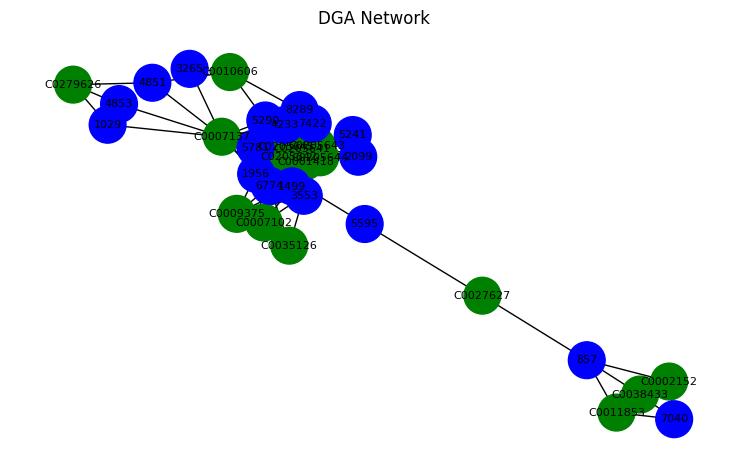

In [6]:
plt.figure(1, figsize=(8, 5))
plt.title("DGA Network")
plt.tight_layout()

color = nx.bipartite.color(G)
color_dict = {"disease": "g", "gene":"b"}
color_list = [color_dict[i[1]] for i in G.nodes.data("bipartite")]
nx.draw(G, pos=nx.spring_layout(G, seed=10), with_labels=True, node_color=color_list, node_size=700, font_size=8)

In [7]:
data = tg.utils.from_networkx(G)

In [8]:
print(data.edge_index.shape)

torch.Size([2, 204])


In [9]:
print(data.is_directed())
print(data.has_isolated_nodes())
print(data.has_self_loops())


False
False
False


In [10]:
data

Data(edge_index=[2, 204], y=[34], bipartite=[34], num_nodes=34)

Split training and testing set

- just split it (pseudo)randomly

In [11]:
import random

SEED = 10
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

train_mask = torch.rand(34) > 0.75
print(train_mask)

tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True, False])


In [12]:
data.train_mask = torch.Tensor(train_mask)
data.x = torch.eye(34)  # identitiy matrix for node features (doesnt do anything)

## GCN

In [13]:
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(5, 5))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                        f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=10), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()


In [14]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(SEED)
        self.gcn1 = GCNConv(34, 4)
        # self.gcn1 = GCNConv(4, 3)
        self.gcn2 = GCNConv(4, 3)
        self.out = Linear(3, 2)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index).relu()
        h = self.gcn2(h, edge_index).relu()
        out = self.out(h)
        return out, h


model = GCN()
print(model)


GCN(
  (gcn1): GCNConv(34, 4)
  (gcn2): GCNConv(4, 3)
  (out): Linear(in_features=3, out_features=2, bias=True)
)


In [15]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes_train = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes_train == target_classes, 1, 0).float())
    
    # Calculate validation accuracy on the whole graph
    predicted_classes_val = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes_val == target_classes, 1, 0).float())

    return loss, h, accuracy, out

losses = []
val_accuracies = []
train_accuracies = []
outputs = []
embeddings = []
num_of_epochs = 5001
for epoch in range(num_of_epochs):
    loss, h, accuracy, out = train(data)
    # Visualize the node embeddings every 10 epochs
    if epoch % 100 == 0:
        # visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)
        print(f"epoch: {epoch:<3}\tloss: {loss:.4f}"
              f"\ttrain-acc:{accuracy['train']:4f}"
              f"\tval-acc:{accuracy['val']:4f}")
    losses.append(loss)
    train_accuracies.append(accuracy["train"])
    val_accuracies.append(accuracy["val"])
    embeddings.append(h)
    outputs.append(out.argmax(axis=1))

epoch: 0  	loss: 0.7351	train-acc:0.400000	val-acc:0.470588
epoch: 100	loss: 0.7114	train-acc:0.400000	val-acc:0.470588
epoch: 200	loss: 0.6899	train-acc:0.400000	val-acc:0.470588
epoch: 300	loss: 0.6614	train-acc:1.000000	val-acc:0.852941
epoch: 400	loss: 0.6210	train-acc:0.800000	val-acc:0.529412
epoch: 500	loss: 0.5715	train-acc:0.800000	val-acc:0.617647
epoch: 600	loss: 0.5171	train-acc:0.800000	val-acc:0.588235
epoch: 700	loss: 0.4638	train-acc:1.000000	val-acc:0.764706
epoch: 800	loss: 0.4160	train-acc:1.000000	val-acc:0.764706
epoch: 900	loss: 0.3738	train-acc:1.000000	val-acc:0.764706
epoch: 1000	loss: 0.3370	train-acc:1.000000	val-acc:0.764706
epoch: 1100	loss: 0.3050	train-acc:1.000000	val-acc:0.764706
epoch: 1200	loss: 0.2776	train-acc:1.000000	val-acc:0.735294
epoch: 1300	loss: 0.2540	train-acc:1.000000	val-acc:0.735294
epoch: 1400	loss: 0.2337	train-acc:1.000000	val-acc:0.764706
epoch: 1500	loss: 0.2160	train-acc:1.000000	val-acc:0.764706
epoch: 1600	loss: 0.2006	train-acc

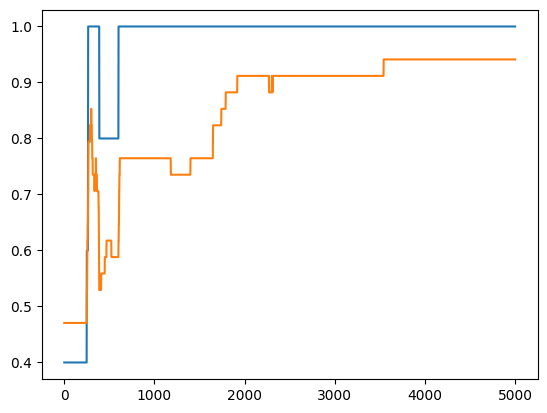

In [16]:
plt.plot(list(range(num_of_epochs)), train_accuracies)
plt.plot(list(range(num_of_epochs)), val_accuracies)

In [17]:
def visualize_network(outputs, losses, accuracies):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 8), squeeze=0)

    for i, ax in enumerate(axes.flatten()):
        i = i * 1000
        nx.draw(
            G,
            pos=nx.spring_layout(G, seed=10),
            with_labels=True,
            node_size=800,
            node_color=outputs[i],
            cmap="hsv",
            vmin=-2,
            vmax=3,
            width=0.8,
            font_size=14,
            ax=ax,
        )
        ax.set_title(
            f"Epoch = {i}\nloss = {losses[i]:0.4f}\naccuracy = {accuracies[i]:0.4f}"
        )
        # ax.set_axis_off()


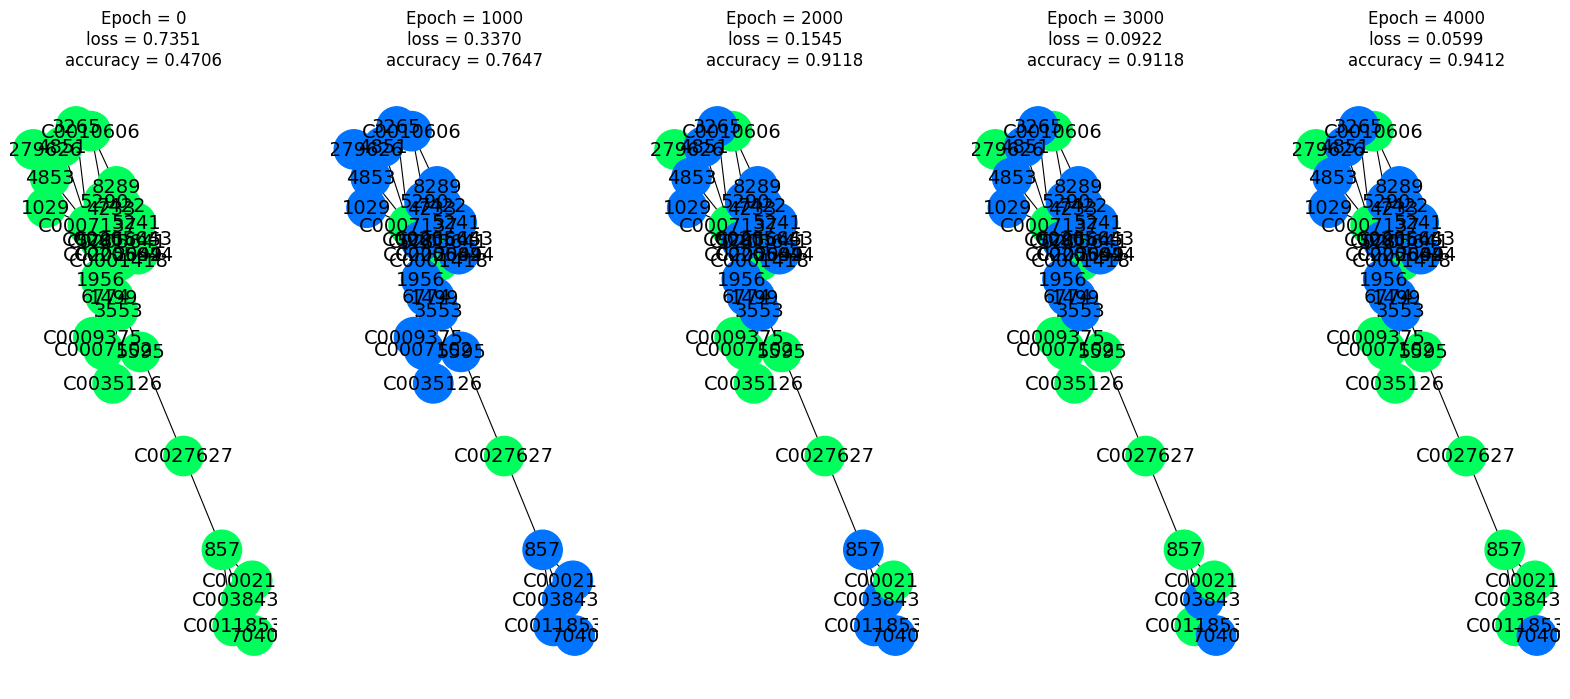

In [18]:
visualize_network(outputs, losses, val_accuracies)

In [19]:
(data.train_mask == True).nonzero()[:, 0]

tensor([ 7, 15, 30, 31, 32])

In [20]:
data.node_stores[0]["y"][data.train_mask]

tensor([0, 0, 1, 1, 1])

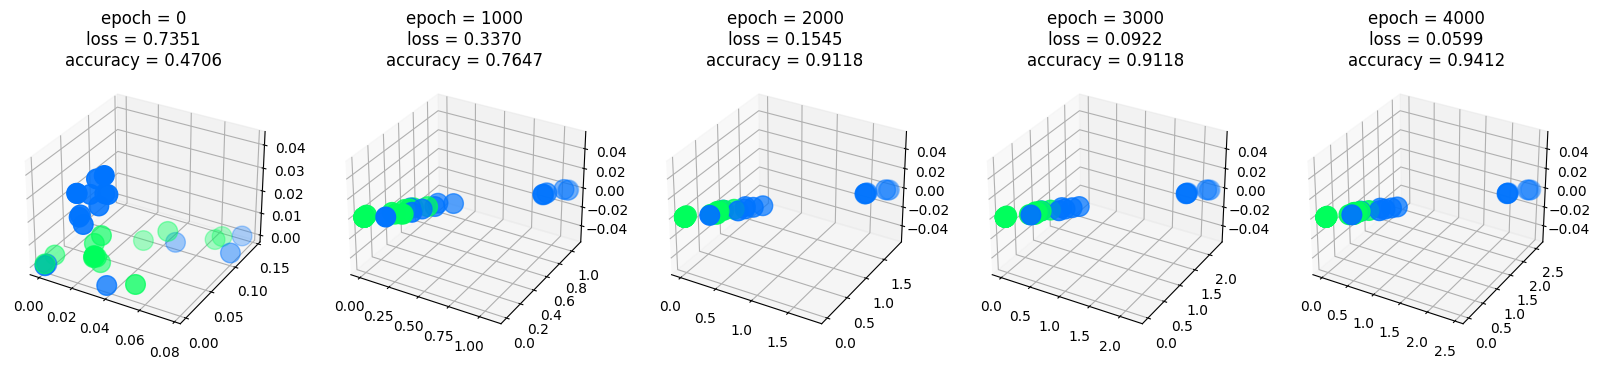

In [21]:
fig = plt.figure(figsize=(20, 8))


for i in range(5):
    # i = i * 50
    ind = i * 1000

    ax = fig.add_subplot(1, 5, i + 1, projection="3d")

    embed = embeddings[ind].detach().cpu().numpy()
    ax.clear()
    ax.scatter(
        embed[:, 0],
        embed[:, 1],
        embed[:, 2],
        s=200,
        c=data.y,
        cmap="hsv",
        vmin=-2,
        vmax=3,
    )

    ax.set_title(
        f"epoch = {ind}\nloss = {losses[ind]:0.4f}\naccuracy = {val_accuracies[ind]:0.4f}"
    )
    # ax.tick_params(
    #     left=False,
    #     bottom=False,
    #     labelleft=False,
    #     labelbottom=False,
    # )
